# Using MLJ to classifiy the MNIST image dataset

In [1]:
using Pkg
const DIR = @__DIR__
Pkg.activate(DIR)
Pkg.instantiate()

using MLJ
using Flux
import MLJFlux
using Random
Random.seed!(123)

MLJ.color_off()

using Plots
pyplot(size=(600, 300*(sqrt(5)-1)));

  Activating environment at `~/Dropbox/Julia7/MLJ/MLJFlux/examples/mnist/Project.toml`
Precompiling project...
  ✓ StatsFuns
  ✓ Distributions
  ✓ MLJBase
  ✓ MLJIteration
  ✓ MLJTuning
  ✓ MLJSerialization
  ✓ MLJModels
  ✓ MLJ
8 dependencies successfully precompiled in 21 seconds (188 already precompiled)
┌ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
└ @ Base loading.jl:1317
┌ Info: Precompiling MLJFlux [094fc8d1-fd35-5302-93ea-dabda2abf845]
└ @ Base loading.jl:1317
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1317


## Basic training

Downloading the MNIST image dataset:

In [2]:
import Flux.Data.MNIST
images, labels = MNIST.images(), MNIST.labels();

In MLJ, integers cannot be used for encoding categorical data, so we
must force the labels to have the `Multiclass` [scientific
type](https://alan-turing-institute.github.io/MLJScientificTypes.jl/dev/). For
more on this, see [Working with Categorical
Data](https://alan-turing-institute.github.io/MLJ.jl/dev/working_with_categorical_data/).

In [3]:
labels = coerce(labels, Multiclass);

Checking scientific types:

In [4]:
@assert scitype(images) <: AbstractVector{<:Image}
@assert scitype(labels) <: AbstractVector{<:Finite}

Looks good.

For general instructions on coercing image data, see [Type coercion
for image
data](https://alan-turing-institute.github.io/MLJScientificTypes.jl/dev/#Type-coercion-for-image-data-1)

In [5]:
images[1]

We start by defining a suitable `Builder` object. This is a recipe
for building the neural network. Our builder will work for images of
any (constant) size, whether they be color or black and white (ie,
single or multi-channel).  The architecture always consists of six
alternating convolution and max-pool layers, and a final dense
layer; the filter size and the number of channels after each
convolution layer is customisable.

In [6]:
import MLJFlux
struct MyConvBuilder
    filter_size::Int
    channels1::Int
    channels2::Int
    channels3::Int
end

flatten(x::AbstractArray) = reshape(x, :, size(x)[end])
half(x) = div(x, 2)

function MLJFlux.build(b::MyConvBuilder, n_in, n_out, n_channels)

    k, c1, c2, c3 = b.filter_size, b.channels1, b.channels2, b.channels3

    mod(k, 2) == 1 || error("`filter_size` must be odd. ")

    p = div(k - 1, 2) # padding to preserve image size on convolution:

    h = n_in[1] |> half |> half |> half # final "image" height
    w = n_in[2] |> half |> half |> half # final "image" width

    return Chain(
        Conv((k, k), n_channels => c1, pad=(p, p), relu),
        MaxPool((2, 2)),
        Conv((k, k), c1 => c2, pad=(p, p), relu),
        MaxPool((2, 2)),
        Conv((k, k), c2 => c3, pad=(p, p), relu),
        MaxPool((2 ,2)),
        flatten,
        Dense(h*w*c3, n_out))
end

**Note.** There is no final `softmax` here, as this is applied by
default in all MLJFLux classifiers. Customisation of this behaviour
is controlled using using the `finaliser` hyperparameter of the
classifier.

We now define the MLJ model. If you have a GPU, substitute
`acceleration=CUDALibs()` below:

In [7]:
ImageClassifier = @load ImageClassifier
clf = ImageClassifier(builder=MyConvBuilder(3, 16, 32, 32),
                      acceleration=CPU1(),
                      batch_size=50,
                      epochs=10)

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /Users/anthony/.julia/packages/MLJModels/zYlo3/src/loading.jl:168


import MLJFlux ✔


ImageClassifier(
    builder = MyConvBuilder(3, 16, 32, 32),
    finaliser = NNlib.softmax,
    optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any, Any}()),
    loss = Flux.Losses.crossentropy,
    epochs = 10,
    batch_size = 50,
    lambda = 0.0,
    alpha = 0.0,
    optimiser_changes_trigger_retraining = false,
    acceleration = CPU1{Nothing}(nothing)) @839

You can add Flux options `optimiser=...` and `loss=...` here. At
present, `loss` must be a Flux-compatible loss, not an MLJ measure.

Binding the model with data in an MLJ machine:

In [8]:
mach = machine(clf, images, labels);

Training for 10 epochs on the first 500 images:

In [9]:
fit!(mach, rows=1:500, verbosity=2);

┌ Info: Training Machine{ImageClassifier{MyConvBuilder,…},…} @110.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/KWyqX/src/machines.jl:342
┌ Info: Loss is 2.239
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/AeMUx/src/core.jl:143
┌ Info: Loss is 2.109
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/AeMUx/src/core.jl:143
┌ Info: Loss is 1.814
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/AeMUx/src/core.jl:143
┌ Info: Loss is 1.269
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/AeMUx/src/core.jl:143
┌ Info: Loss is 0.7602
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/AeMUx/src/core.jl:143
┌ Info: Loss is 0.5445
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/AeMUx/src/core.jl:143
┌ Info: Loss is 0.4606
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/AeMUx/src/core.jl:143
┌ Info: Loss is 0.341
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/AeMUx/src/core.jl:143
┌ Info: Loss is 0.2975
└ @ MLJFlux /Users/anthony/.julia/packages/MLJFlux/AeMUx/src/core.jl:1

Inspecting:

In [10]:
report(mach)

(training_losses = Float32[2.3228688, 2.2390091, 2.1091332, 1.8143247, 1.2688795, 0.76020443, 0.54449147, 0.46060592, 0.34104383, 0.2975061, 0.25796312],)

In [11]:
chain = fitted_params(mach)

(chain = Chain(Chain(Conv((3, 3), 1=>16, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 16=>32, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), Conv((3, 3), 32=>32, relu), MaxPool((2, 2), pad = (0, 0, 0, 0), stride = (2, 2)), flatten, Dense(288, 10)), softmax),)

In [12]:
Flux.params(chain)[2]

16-element Vector{Float32}:
  0.009390121
  0.07259897
 -0.0038282399
  0.016712524
  0.001980654
  0.027747674
 -0.0007374671
  0.00018301565
  0.07081605
  0.06926995
  0.0020753616
  0.0032082414
  0.015448393
  0.008061441
  0.023986094
  0.04710653

Adding 20 more epochs:

In [13]:
clf.epochs = clf.epochs + 20
fit!(mach, rows=1:500);

┌ Info: Updating Machine{ImageClassifier{MyConvBuilder,…},…} @110.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/KWyqX/src/machines.jl:343
Optimising neural net:100%[=========================] Time: 0:00:07


Computing an out-of-sample estimate of the loss:

In [14]:
predicted_labels = predict(mach, rows=501:1000);
cross_entropy(predicted_labels, labels[501:1000]) |> mean

0.36543968f0

Or, in one line (after resetting the RNG seed to ensure the same
result):

In [15]:
Random.seed!(123)
evaluate!(mach,
          resampling=Holdout(fraction_train=0.5),
          measure=cross_entropy,
          rows=1:1000,
          verbosity=0)

┌───────────────────────┬───────────────┬────────────────┐
│ _.measure             │ _.measurement │ _.per_fold     │
├───────────────────────┼───────────────┼────────────────┤
│ LogLoss{Float64} @358 │ 0.365         │ Float32[0.365] │
└───────────────────────┴───────────────┴────────────────┘
_.per_observation = [[[6.12, 0.182, ..., 0.00043]]]
_.fitted_params_per_fold = [ … ]
_.report_per_fold = [ … ]


## Wrapping the MLJFlux model with iteration controls

Any iterative MLJ model implementing the warm restart functionality
illustrated above for `ImageClassifier` can be wrapped in *iteration
controls*, as we demonstrate next. For more on MLJ's
`IteratedModel` wrapper, see the [MLJ
documentation](https://alan-turing-institute.github.io/MLJ.jl/dev/controlling_iterative_models/).

The "self-iterating" model, called `imodel` below, is for iterating the
image classifier defined above until one of the following stopping
criterion apply:

- `Patience(3)` (3 consecutive increases in the loss)

- `InvalidValue()` (an out-of-sample loss, or a training loss,
  is `NaN`, `Inf`, or `-Inf`)

- `TimeLimit(t=1/60)` (training time has exceeded one minute)

Additionally, training a machine bound to `imodel` will:

- save a snapshot of the machine every three epochs

- record the out-of-sample loss and training losses for plotting

For a complete list of controls, see [this
table](https://alan-turing-institute.github.io/MLJ.jl/dev/controlling_iterative_models/#Controls-provided).

In [17]:
losses = []
training_losses = [];

add_loss(loss) = push!(losses, loss)
add_training_loss(losses) = push!(training_losses, losses[end])

imodel = IteratedModel(model=clf,
                       controls=[Step(1),      # train one epoch at a time
                                 Patience(2),
                                 InvalidValue(),
                                 TimeLimit(0.5),
                                 Save(joinpath(DIR, "mnist_machine.jlso")),
                                 WithLossDo(), # for logging to `Info`
                                 WithLossDo(add_loss),
                                 WithTrainingLossesDo(add_training_loss)],
                       resampling=Holdout(fraction_train=0.7),
                       measure=log_loss,
                       retrain=false)

ProbabilisticIteratedModel(
    model = ImageClassifier(
            builder = MyConvBuilder(3, 16, 32, 32),
            finaliser = NNlib.softmax,
            optimiser = ADAM(0.001, (0.9, 0.999), IdDict{Any, Any}()),
            loss = Flux.Losses.crossentropy,
            epochs = 30,
            batch_size = 50,
            lambda = 0.0,
            alpha = 0.0,
            optimiser_changes_trigger_retraining = false,
            acceleration = CPU1{Nothing}(nothing)),
    controls = Any[Step(1), Patience(2), InvalidValue(), TimeLimit(Dates.Millisecond(1800000)), Save{Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}}("/Users/anthony/Dropbox/Julia7/MLJ/MLJFlux/examples/mnist/mnist_machine.jlso", Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}()), WithLossDo{IterationControl.var"#16#18"}(IterationControl.var"#16#18"(), false, nothing), WithLossDo{typeof(add_loss)}(add_loss, false, nothing), WithTrainingLossesDo{typeof(add_training_los

Binding our self-iterating model to data:

In [18]:
mach = machine(imodel, images, labels)

Machine{ProbabilisticIteratedModel{ImageClassifier{MyConvBuilder,…}},…} @130 trained 0 times; does not cache data
  args: 
    1:	Source @566 ⏎ `AbstractVector{GrayImage{28, 28}}`
    2:	Source @832 ⏎ `AbstractVector{Multiclass{10}}`


And training on the first 500 images:

In [19]:
fit!(mach, rows=1:500)

┌ Info: Training Machine{ProbabilisticIteratedModel{ImageClassifier{MyConvBuilder,…}},…} @130.
└ @ MLJBase /Users/anthony/.julia/packages/MLJBase/KWyqX/src/machines.jl:342
┌ Info: Saving "/Users/anthony/Dropbox/Julia7/MLJ/MLJFlux/examples/mnist/mnist_machine1.jlso". 
└ @ MLJSerialization /Users/anthony/.julia/packages/MLJSerialization/UX4yW/src/controls.jl:33
┌ Info: loss: 2.2725065
└ @ IterationControl /Users/anthony/.julia/packages/IterationControl/TOn4C/src/controls.jl:280
┌ Info: Saving "/Users/anthony/Dropbox/Julia7/MLJ/MLJFlux/examples/mnist/mnist_machine2.jlso". 
└ @ MLJSerialization /Users/anthony/.julia/packages/MLJSerialization/UX4yW/src/controls.jl:33
┌ Info: loss: 2.212589
└ @ IterationControl /Users/anthony/.julia/packages/IterationControl/TOn4C/src/controls.jl:280
┌ Info: Saving "/Users/anthony/Dropbox/Julia7/MLJ/MLJFlux/examples/mnist/mnist_machine3.jlso". 
└ @ MLJSerialization /Users/anthony/.julia/packages/MLJSerialization/UX4yW/src/controls.jl:33
┌ Info: loss: 2.10931

Machine{ProbabilisticIteratedModel{ImageClassifier{MyConvBuilder,…}},…} @130 trained 1 time; does not cache data
  args: 
    1:	Source @566 ⏎ `AbstractVector{GrayImage{28, 28}}`
    2:	Source @832 ⏎ `AbstractVector{Multiclass{10}}`


A comparison of the training and out-of-sample losses:

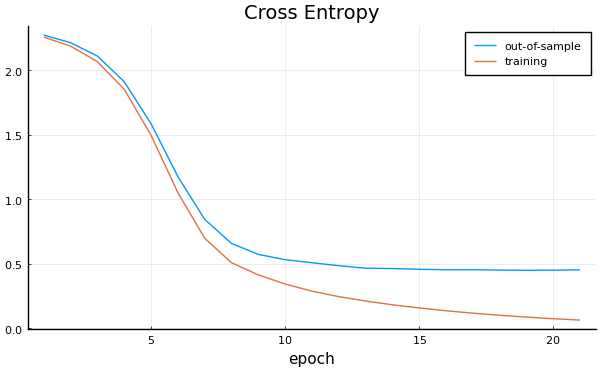

In [20]:
plot(losses,
     title="Cross Entropy",
     xlab = "epoch",
     label="out-of-sample")
plot!(training_losses, label="training")

Retrieving a snapshot for a prediction:

In [23]:
mach2 = machine(joinpath(DIR, "mnist_machine5.jlso"))

Machine{ImageClassifier{MyConvBuilder,…},…} @200 trained 1 time; caches data
  args: 


In [24]:
predict_mode(mach2, images[501:503])

3-element CategoricalArrays.CategoricalArray{Int64,1,UInt32}:
 2
 7
 3

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*